Installing the PyCoinGecko Library to Access Cryptocurrency Data



In [2]:
!pip install pycoingecko


Fetching and Preparing 1-Year Historical Bitcoin Price Data Using CoinGecko API



In [3]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime, timedelta
import time

cg = CoinGeckoAPI()

end_date = datetime.today()
start_date = end_date - timedelta(days=365)

from_ts = int(start_date.timestamp())
to_ts = int(end_date.timestamp())

data = cg.get_coin_market_chart_range_by_id(
    id='bitcoin',
    vs_currency='usd',
    from_timestamp=from_ts,
    to_timestamp=to_ts
)

df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df['volume'] = [v[1] for v in data['total_volumes']]
df['market_cap'] = [m[1] for m in data['market_caps']]

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df = df.resample('1D').mean()
df = df[~df.index.duplicated()]
df.sort_index(inplace=True)

print(df.shape)
print(df.index.min(), df.index.max())
df.head()


(365, 3)
2024-06-29 00:00:00 2025-06-28 00:00:00


,price,volume,market_cap
timestamp,,,
2024-06-29,60317.096979,2.439942e+10,1.189570e+12
2024-06-30,60864.443162,1.143511e+10,1.199793e+12
2024-07-01,62734.393839,1.737359e+10,1.236677e+12
2024-07-02,62819.822269,2.557307e+10,1.238799e+12
2024-07-03,62042.565037,1.810053e+10,1.222902e+12


EDA

In [4]:
print(df.describe())


               price        volume    market_cap
count     365.000000  3.650000e+02  3.650000e+02
mean    83668.308624  4.241960e+10  1.657416e+12
std     17505.209713  2.741415e+10  3.497002e+11
min     53923.356111  7.771135e+09  1.064889e+12
25%     65162.236252  2.545711e+10  1.287151e+12
50%     86960.855549  3.451207e+10  1.724854e+12
75%     98084.342793  4.925517e+10  1.942835e+12
max    111560.356938  1.904603e+11  2.214712e+12


In [5]:
print(df.isnull().sum())


price         0
volume        0
market_cap    0
dtype: int64


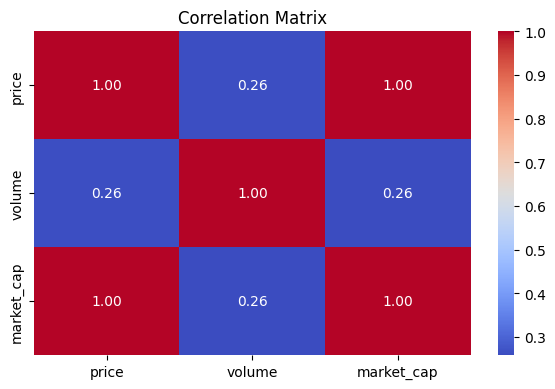

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


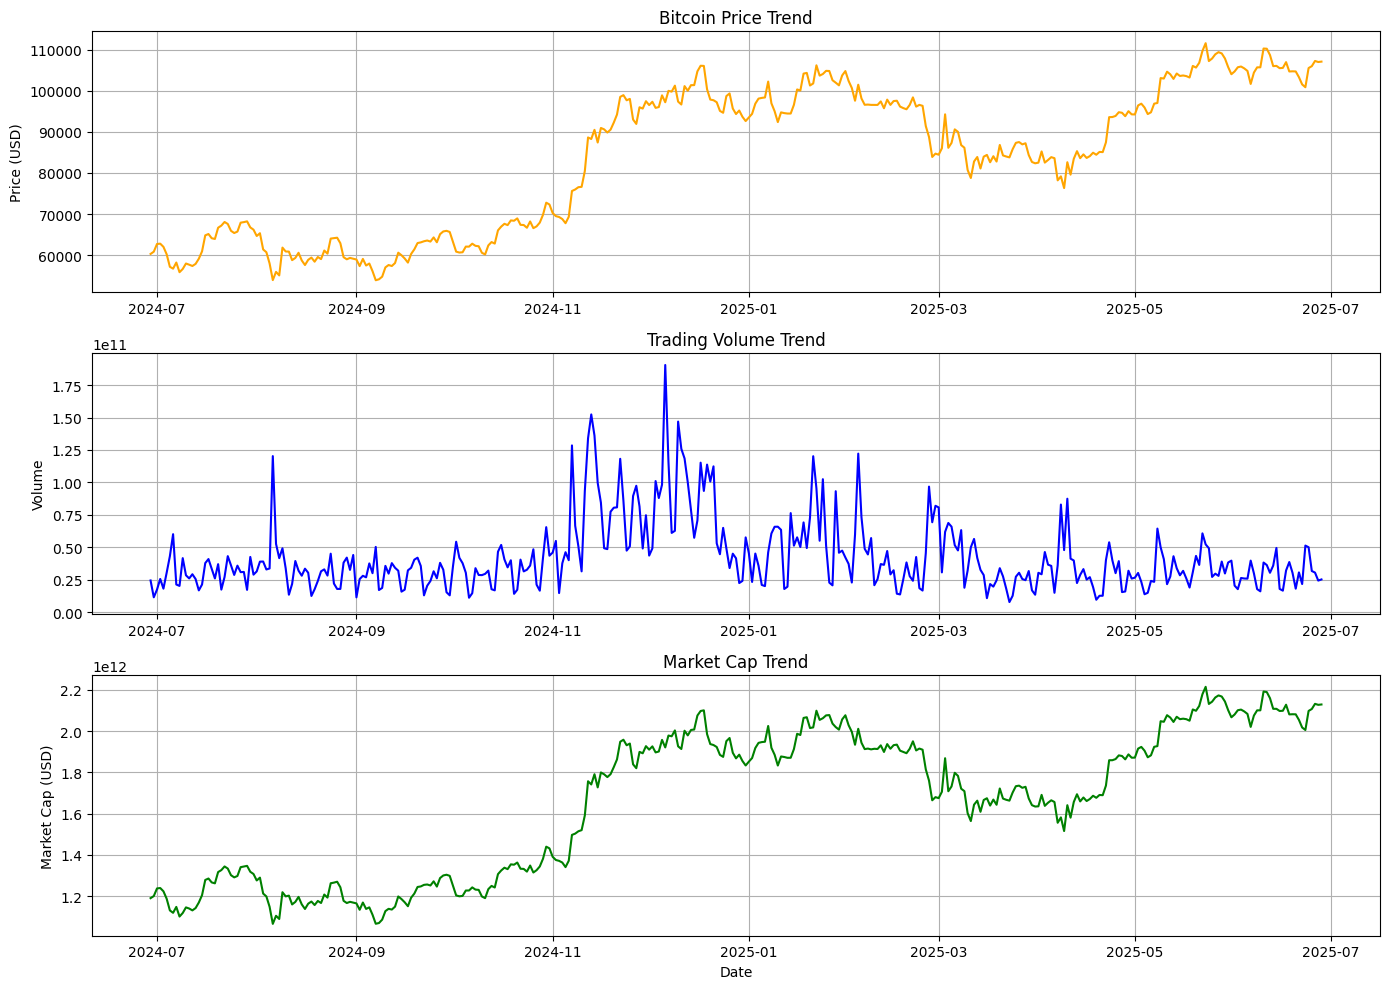

In [7]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['price'], color='orange')
plt.title('Bitcoin Price Trend')
plt.ylabel('Price (USD)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df.index, df['volume'], color='blue')
plt.title('Trading Volume Trend')
plt.ylabel('Volume')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df.index, df['market_cap'], color='green')
plt.title('Market Cap Trend')
plt.ylabel('Market Cap (USD)')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['price'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.1481264319889146
p-value: 0.6955032955009428


Calculating Daily Bitcoin Price Changes



In [9]:
df['price_diff'] = df['price'].diff()


In [10]:
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df['price_diff'].dropna())
print('ADF Statistic (diff):', result_diff[0])
print('p-value (diff):', result_diff[1])


ADF Statistic (diff): -20.00785691927838
p-value (diff): 0.0


Creating the Target Column



In [11]:
df['target'] = (df['price'].shift(-1) > df['price']).astype(int)

df.dropna(subset=['target'], inplace=True)

df[['price', 'target']].head()


,price,target
timestamp,,
2024-06-29,60317.096979,1
2024-06-30,60864.443162,1
2024-07-01,62734.393839,1
2024-07-02,62819.822269,0
2024-07-03,62042.565037,0


Target Correlation *Heatmap*

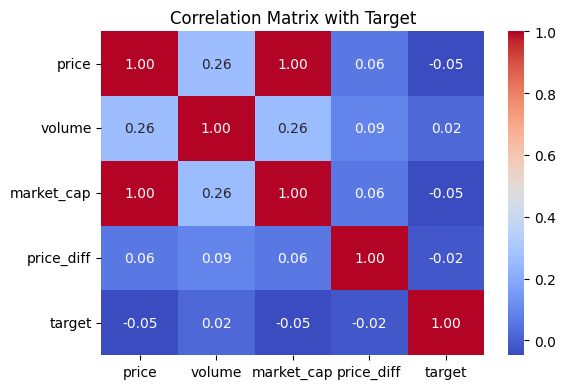

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Target')
plt.tight_layout()
plt.show()


Calculating Daily Percentage Change in Bitcoin Price



In [13]:
# Create percentage change in price
df['price_change_pct'] = df['price'].pct_change()

# Remove the first row (which will contain NaN)
df.dropna(subset=['price_change_pct'], inplace=True)

#Preview
df[['price', 'price_change_pct', 'target']].head()


,price,price_change_pct,target
timestamp,,,
2024-06-30,60864.443162,0.009074,1
2024-07-01,62734.393839,0.030723,1
2024-07-02,62819.822269,0.001362,0
2024-07-03,62042.565037,-0.012373,0
2024-07-04,60244.680764,-0.028978,0


Target Correlation *Heatmap*

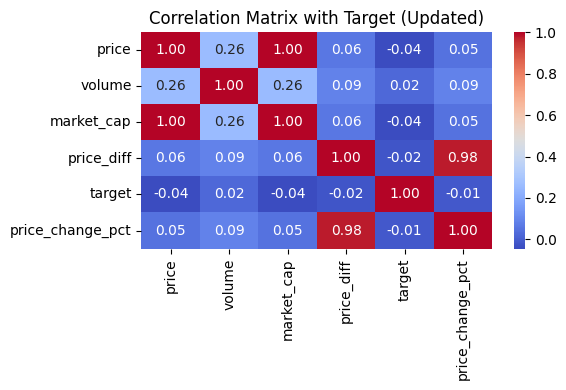

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute updated correlation matrix
corr = df.corr()

# Plot the new heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Target (Updated)')
plt.tight_layout()
plt.show()


Adding Lag Feature: Previous Day's Price



In [15]:
# Add price from the previous day as a feature
df['price_lag_1'] = df['price'].shift(1)

# Drop any rows with NaN due to shifting
df.dropna(subset=['price_lag_1'], inplace=True)

# Preview
df[['price', 'price_lag_1', 'price_change_pct', 'target']].head()


,price,price_lag_1,price_change_pct,target
timestamp,,,,
2024-07-01,62734.393839,60864.443162,0.030723,1
2024-07-02,62819.822269,62734.393839,0.001362,0
2024-07-03,62042.565037,62819.822269,-0.012373,0
2024-07-04,60244.680764,62042.565037,-0.028978,0
2024-07-05,57189.174124,60244.680764,-0.050718,0


Adding Lag 2 Feature: Price from Two Days Ago



In [16]:
# Add price from two days ago
df['price_lag_2'] = df['price'].shift(2)

df.dropna(subset=['price_lag_2'], inplace=True)

# Preview
df[['price', 'price_lag_1', 'price_lag_2', 'target']].head()


,price,price_lag_1,price_lag_2,target
timestamp,,,,
2024-07-03,62042.565037,62819.822269,62734.393839,0
2024-07-04,60244.680764,62042.565037,62819.822269,0
2024-07-05,57189.174124,60244.680764,62042.565037,0
2024-07-06,56739.862851,57189.174124,60244.680764,1
2024-07-07,58230.484154,56739.862851,57189.174124,0


Adding 3-Day Rolling Average Feature



In [17]:
# 3-day rolling mean of price
df['rolling_mean_3'] = df['price'].rolling(window=3).mean()

# Drop rows with NaN from rolling
df.dropna(subset=['rolling_mean_3'], inplace=True)

# Preview
df[['price', 'price_lag_1', 'price_lag_2', 'rolling_mean_3', 'target']].head()


,price,price_lag_1,price_lag_2,rolling_mean_3,target
timestamp,,,,,
2024-07-05,57189.174124,60244.680764,62042.565037,59825.473309,0
2024-07-06,56739.862851,57189.174124,60244.680764,58057.905913,1
2024-07-07,58230.484154,56739.862851,57189.174124,57386.507043,0
2024-07-08,55880.375378,58230.484154,56739.862851,56950.240794,1
2024-07-09,56665.140734,55880.375378,58230.484154,56925.333422,1


Adding 3-Day Rolling Standard Deviation Feature



In [18]:
# 3-day rolling standard deviation of price
df['rolling_std_3'] = df['price'].rolling(window=3).std()

# Drop rows with NaN from rolling
df.dropna(subset=['rolling_std_3'], inplace=True)

# Preview
df[['price', 'rolling_mean_3', 'rolling_std_3', 'target']].head()


,price,rolling_mean_3,rolling_std_3,target
timestamp,,,,
2024-07-07,58230.484154,57386.507043,764.652325,0
2024-07-08,55880.375378,56950.240794,1189.095023,1
2024-07-09,56665.140734,56925.333422,1196.464789,1
2024-07-10,57988.303512,56844.606541,1065.362022,0
2024-07-11,57704.202284,57452.548843,696.553677,0


Adding Volume Lag Feature: Volume from Previous Day



In [19]:
# Volume from previous day
df['volume_lag_1'] = df['volume'].shift(1)

# Drop rows with NaN from shift
df.dropna(subset=['volume_lag_1'], inplace=True)

# Preview
df[['volume', 'volume_lag_1', 'target']].head()


,volume,volume_lag_1,target
timestamp,,,
2024-07-08,2.021191e+10,2.129391e+10,1
2024-07-09,4.161427e+10,2.021191e+10,1
2024-07-10,2.841385e+10,4.161427e+10,0
2024-07-11,2.598766e+10,2.841385e+10,0
2024-07-12,2.919665e+10,2.598766e+10,1


Adding Percentage Change in Volume Feature



In [20]:
# Percentage change in volume
df['volume_change_pct'] = df['volume'].pct_change()

# Drop rows with NaN
df.dropna(subset=['volume_change_pct'], inplace=True)

# Preview
df[['volume', 'volume_change_pct', 'target']].head()


,volume,volume_change_pct,target
timestamp,,,
2024-07-09,4.161427e+10,1.058898,1
2024-07-10,2.841385e+10,-0.317209,0
2024-07-11,2.598766e+10,-0.085388,0
2024-07-12,2.919665e+10,0.123482,1
2024-07-13,2.550448e+10,-0.126459,1


Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    'price', 'price_change_pct', 'price_lag_1', 'price_lag_2',
    'rolling_mean_3', 'rolling_std_3',
    'volume', 'volume_lag_1', 'volume_change_pct'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Check the shape
print(X_train.shape, X_test.shape)


(284, 9) (71, 9)


1 Train and Evaluate Logistic Regression (Basic Version)



```
`# This is formatted as code`
```



In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5352112676056338
Precision: 1.0
Recall: 0.13157894736842105
F1 Score: 0.23255813953488372
Confusion Matrix:
 [[33  0]
 [33  5]]


Adding RSI (Relative Strength Index) Indicator



In [23]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Apply RSI to price column
df['rsi_14'] = compute_rsi(df['price'], period=14)

# Drop NaNs from RSI
df.dropna(subset=['rsi_14'], inplace=True)

# Preview
df[['price', 'rsi_14']].head()


,price,rsi_14
timestamp,,
2024-07-22,68088.139963,88.004315
2024-07-23,67607.713399,85.278178
2024-07-24,65942.417465,75.090076
2024-07-25,65403.535130,73.902217
2024-07-26,65749.963620,75.909791


Using MACD and Signal Line to Capture Price Trends



In [24]:
# Compute MACD and Signal Line
ema_12 = df['price'].ewm(span=12, adjust=False).mean()
ema_26 = df['price'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Drop NaNs from MACD
df.dropna(subset=['macd', 'macd_signal'], inplace=True)

# Preview
df[['price', 'macd', 'macd_signal']].head()


,price,macd,macd_signal
timestamp,,,
2024-07-22,68088.139963,0.000000,0.000000
2024-07-23,67607.713399,-38.324626,-7.664925
2024-07-24,65942.417465,-200.758415,-46.283623
2024-07-25,65403.535130,-368.721274,-110.771153
2024-07-26,65749.963620,-468.478834,-182.312690


Feature Preparation and Standardization for Modeling



In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the final set of features to be used in the model
features = [
    'price', 'price_change_pct', 'price_lag_1', 'price_lag_2',
    'rolling_mean_3', 'rolling_std_3',
    'volume', 'volume_lag_1', 'volume_change_pct',
    'rsi_14', 'macd', 'macd_signal'
]

# Define input features (X) and target variable (y)
X = df[features]
y = df['target']

# Re-split the data (since some rows were dropped after adding new indicators)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Do not shuffle for time series
)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data using same scaler

# Print the shape of the resulting datasets
print(X_train_scaled.shape, X_test_scaled.shape)


(273, 12) (69, 12)


Training a Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5507246376811594
Precision: 0.875
Recall: 0.1891891891891892
F1 Score: 0.3111111111111111
Confusion Matrix:
 [[31  1]
 [30  7]]


In [27]:
print(y.value_counts(normalize=True))


target
1    0.502924
0    0.497076
Name: proportion, dtype: float64


Visualizing Feature Importance in Random Forest



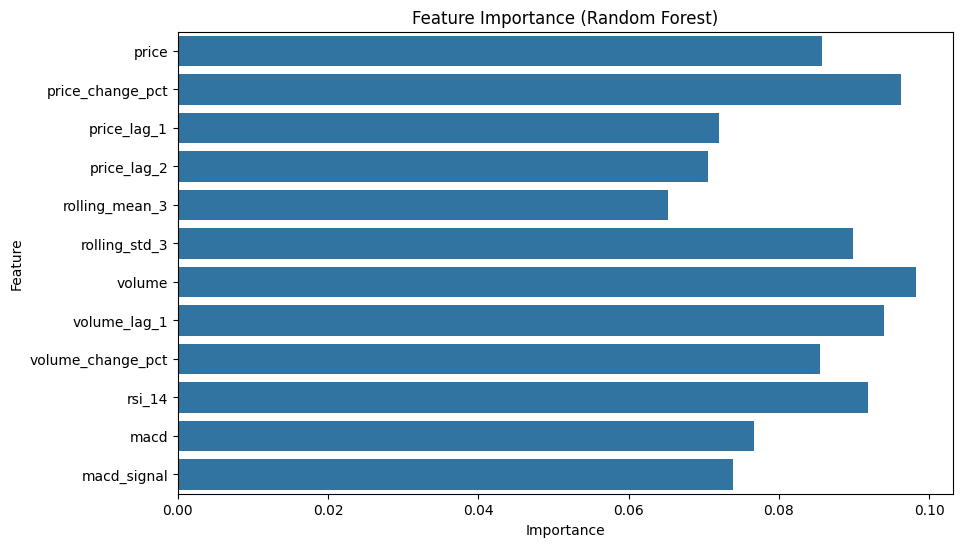

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [29]:
importances = model.feature_importances_
print(importances)
print("Sum:", importances.sum())  # لازم = 1


[0.08577811 0.09632248 0.07203063 0.07051661 0.06524683 0.08992944
 0.09824309 0.09397213 0.08550156 0.09183517 0.07671374 0.07391021]
Sum: 1.0000000000000002


Training an XGBoost model

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:51:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5072463768115942
Precision: 0.6363636363636364
Recall: 0.1891891891891892
F1 Score: 0.2916666666666667
Confusion Matrix:
 [[28  4]
 [30  7]]


Adding 7-Day SMA and EMA for Trend Smoothing



In [31]:
# 7-day SMA and EMA
df['sma_7'] = df['price'].rolling(window=7).mean()
df['ema_7'] = df['price'].ewm(span=7, adjust=False).mean()


Adding Bollinger Bands for Price Volatility Analysis



In [32]:
# 20-day rolling mean & std
df['bb_ma_20'] = df['price'].rolling(window=20).mean()
df['bb_std_20'] = df['price'].rolling(window=20).std()
df['bb_upper'] = df['bb_ma_20'] + 2 * df['bb_std_20']
df['bb_lower'] = df['bb_ma_20'] - 2 * df['bb_std_20']


Adding Rate of Change and Momentum Indicators



In [33]:
# Rate of Change
df['roc'] = df['price'].pct_change(periods=5)

# Momentum
df['momentum'] = df['price'] - df['price'].shift(5)


In [34]:
print(df.isnull().sum())


price                 0
volume                0
market_cap            0
price_diff            0
target                0
price_change_pct      0
price_lag_1           0
price_lag_2           0
rolling_mean_3        0
rolling_std_3         0
volume_lag_1          0
volume_change_pct     0
rsi_14                0
macd                  0
macd_signal           0
sma_7                 6
ema_7                 0
bb_ma_20             19
bb_std_20            19
bb_upper             19
bb_lower             19
roc                   5
momentum              5
dtype: int64


In [35]:
df.dropna(inplace=True)


In [36]:
print(df.isnull().sum())


price                0
volume               0
market_cap           0
price_diff           0
target               0
price_change_pct     0
price_lag_1          0
price_lag_2          0
rolling_mean_3       0
rolling_std_3        0
volume_lag_1         0
volume_change_pct    0
rsi_14               0
macd                 0
macd_signal          0
sma_7                0
ema_7                0
bb_ma_20             0
bb_std_20            0
bb_upper             0
bb_lower             0
roc                  0
momentum             0
dtype: int64


In [37]:
df['target'].value_counts(normalize=True)


,proportion
target,
1,0.510836
0,0.489164


Adding MACD Histogram for Momentum Strength Detection



In [38]:
df['macd_hist'] = df['macd'] - df['macd_signal']


In [39]:
features = [
    'price', 'price_change_pct', 'price_lag_1', 'price_lag_2',
    'rolling_mean_3', 'rolling_std_3',
    'volume', 'volume_lag_1', 'volume_change_pct',
    'rsi_14', 'macd', 'macd_signal', 'macd_hist'
]


Adding OBV (On-Balance Volume) Indicator



In [40]:
df['obv'] = 0
df['price_diff'] = df['price'].diff()

df.loc[df['price_diff'] > 0, 'obv'] = df['volume']
df.loc[df['price_diff'] < 0, 'obv'] = -df['volume']
df['obv'] = df['obv'].cumsum().fillna(0)

df.drop(columns=['price_diff'], inplace=True)

features.append('obv')


/tmp/ipython-input-40-2776993012.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.94032964e+10 3.19555762e+10 3.03682389e+10 1.24674371e+10
 2.40313302e+10 3.29609650e+10 4.50386658e+10 2.20291534e+10
 1.78752301e+10 3.25633340e+10 2.80127823e+10 3.75503807e+10
 1.70484484e+10 1.86448237e+10 3.56554194e+10 2.96760933e+10
 3.41778599e+10 3.19197407e+10 3.41911701e+10 4.04453394e+10
 4.19590807e+10 3.55878305e+10 1.29380831e+10 2.03493654e+10
 3.14909846e+10 3.79955689e+10 3.26649175e+10 1.53429110e+10
 3.77111384e+10 3.03490598e+10 1.45924229e+10 3.20086593e+10
 1.76659636e+10 4.65537961e+10 5.17979329e+10 4.06404954e+10
 3.99849566e+10 1.72538634e+10 3.58926066e+10 2.11694678e+10
 1.65333857e+10 4.19905404e+10 6.54877820e+10 4.00250216e+10
 1.28492535e+11 6.65903961e+10 5.06874684e+10 3.14309061e+10
 9.34731262e+10 1.33959805e+11 1.36046310e+11 8.43824857e+10
 7.73917242e+10 8.04932350e+10 8.074727

Short & Long-Term Volume Trends



In [41]:
df['volume_ma_3'] = df['volume'].rolling(window=3).mean()
df['volume_ma_7'] = df['volume'].rolling(window=7).mean()

features += ['volume_ma_3', 'volume_ma_7']


Training an XGBoost Model with Class Imbalance Handling



In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:51:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [43]:
from sklearn.metrics import classification_report

y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Threshold
threshold = 0.3
y_pred = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.53      0.88      0.66        32
           1       0.67      0.24      0.36        33

    accuracy                           0.55        65
   macro avg       0.60      0.56      0.51        65
weighted avg       0.60      0.55      0.50        65



In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.5384615384615384
Precision: 0.6363636363636364
Recall: 0.21212121212121213
F1 Score: 0.3181818181818182
Confusion Matrix:
 [[28  4]
 [26  7]]


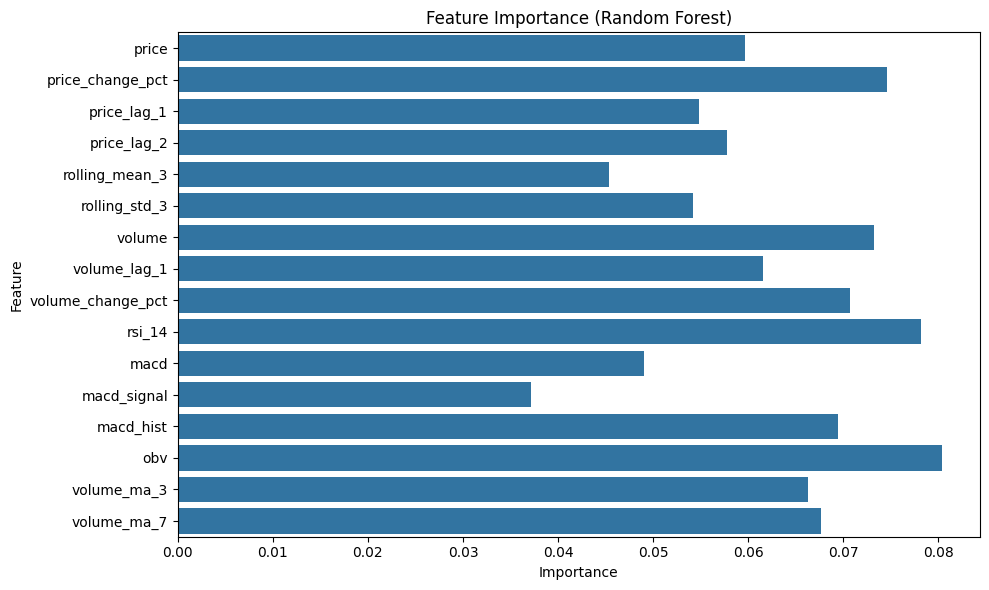

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

selected_features = [
    'obv',
    'price_change_pct',
    'rsi_14',
    'volume',
    'volume_change_pct',
    'macd_hist',
    'volume_ma_3',
    'volume_ma_7'
]

X = df[selected_features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5846153846153846
Precision: 0.8
Recall: 0.24242424242424243
F1 Score: 0.37209302325581395
Confusion Matrix:
 [[30  2]
 [25  8]]
